In [1]:
from os import listdir
from os.path import isfile, join

In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
sift = cv.xfeatures2d.SIFT_create()
from pyquaternion import Quaternion
import pandas as pd
fx = 517.3  # focal length x
fy = 516.5  # focal length y
cx = 318.6  # optical center x
cy = 255.3  # optical center y

In [3]:

def calcTransform(img1, img2, h1, h2):
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    img1_idx = []
    img2_idx = []
    img1_points = []
    img2_points = []
    X_1 = np.array([0.0, 0.0, 0.0])
    X_2 = np.array([0.0, 0.0, 0.0])
    samples = 0
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            x,y = kp1[m.queryIdx].pt
            r1, c1 = int(y), int(x)
            x,y = kp2[m.trainIdx].pt
            r2, c2 = int(y), int(x)
            if h1[r1,c1] != 0 and h2[r2,c2] != 0:
                img1_idx.append(m.queryIdx)
                x = kp1[m.queryIdx].pt[0]
                y = kp1[m.queryIdx].pt[1]
                img1_points.append([(x - cx) * h1[r1,c1]/ fx, (y - cy) * h1[r1,c1]/ fy, h1[r1,c1]])
                X_1 += img1_points[-1]
                img2_idx.append(m.trainIdx)
                x = kp2[m.trainIdx].pt[0]
                y = kp2[m.trainIdx].pt[1]
                img2_points.append([(x - cx) * h2[r2,c2]/ fx, (y - cy) * h2[r2,c2]/ fy, h2[r2,c2]])
                X_2 += img2_points[-1]
                samples += 1
    X_1 /= samples
    X_2 /= samples
    X1_points = np.array(img1_points)
    X2_points = np.array(img2_points)
    SVD_input = (X1_points-X_1).T @ (X2_points-X_2)
    U,S,V = np.linalg.svd(SVD_input)
    R = V.T @ U.T
    t = X_2 - R @ X_1
    transformation = np.zeros((4,4))
    transformation[0:3,0:3] = R
    transformation[0:3,3] = t
    transformation[3,3] = 1
    return transformation
    

In [16]:
def transform_2d(img1, img2):
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    points1 = []
    points2 = []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            points1.append(kp1[m.queryIdx].pt)
            points2.append(kp2[m.trainIdx].pt)
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    E, mask = cv.findEssentialMat(np.array(points1), np.array(points2), K)
    R, _, t = cv.decomposeEssentialMat(E)
    transformation = np.zeros((4,4))
    transformation[0:3,0:3] = R
    transformation[0:3,3] = t[0]
    transformation[3,3] = 1
    return transformation

In [6]:
img1 = cv.imread('rgbd_dataset_freiburg1_floor/rgb/1305033527.670034.png',0)          # queryImage
img2 = cv.imread('rgbd_dataset_freiburg1_floor/rgb/1305033527.701984.png',0)          # trainImage
h1 = cv.imread('rgbd_dataset_freiburg1_floor/depth/1305033527.667207.png',-cv.IMREAD_ANYDEPTH)/5000          # queryImage
h2 = cv.imread('rgbd_dataset_freiburg1_floor/depth/1305033527.699102.png',-cv.IMREAD_ANYDEPTH)/5000          # trainImage

In [189]:
transformation = calcTransform(img1, img2, h1, h2)

In [190]:
transformation

array([[ 9.99996237e-01, -2.74266717e-03,  6.37649434e-05,
         6.20032281e+00],
       [ 2.74266931e-03,  9.99996238e-01, -3.34948109e-05,
        -4.46119299e+00],
       [-6.36728384e-05,  3.36695710e-05,  9.99999997e-01,
        -7.75546210e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [182]:
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
img1_idx = []
img2_idx = []
img1_points = []
img2_points = []
X_1 = np.array([0.0, 0.0, 0.0])
X_2 = np.array([0.0, 0.0, 0.0])
samples = 0
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        x,y = kp1[m.queryIdx].pt
        r1, c1 = int(y), int(x)
        x,y = kp2[m.trainIdx].pt
        r2, c2 = int(y), int(x)
        if h1[r1,c1] != 0 and h2[r2,c2] != 0:
            img1_idx.append(m.queryIdx)
            img1_points.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], h1[r1,c1]])
            X_1 += img1_points[-1]
            img2_idx.append(m.trainIdx)
            img2_points.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], h2[r2,c2]])
            X_2 += img2_points[-1]
            samples += 1
X_1 /= samples
X_2 /= samples
X1_points = np.array(img1_points)
X2_points = np.array(img2_points)
SVD_input = (X1_points-X_1).T @ (X2_points-X_2)
U,S,V = np.linalg.svd(SVD_input)
R = V.T @ U.T
t = X_2 - R @ X_1

In [178]:
t

array([ 5.84760282, -4.33259985, -0.00854073])

In [161]:
X_1

array([[246.47652797, 312.09240803,   1.30344196]])

In [162]:
X1_points

array([[  9.08279037, 432.36920166,   1.0284    ],
       [ 13.30071068, 423.29031372,   1.0474    ],
       [ 16.52820015, 468.69778442,   0.9318    ],
       ...,
       [583.84448242, 410.84631348,   1.0222    ],
       [585.01202393, 266.62384033,   1.171     ],
       [585.15313721, 227.38044739,   1.1328    ]])

In [60]:
mypath = "rgbd_dataset_freiburg1_floor/rgb/"
rgb_files = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])
mypath = "rgbd_dataset_freiburg1_floor/depth/"
depth_files = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])

In [80]:
last_rgb = None
last_h = None
translation = np.array([1.2764, -0.9763, 0.6837, 1])
rotation = Quaternion(0.8187, 0.3639, -0.1804, -0.4060)
position = np.zeros((4,4))
position[0:3,0:3] = rotation.rotation_matrix
position[:, 3] = translation
positions = []
i = 0
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
for rgb, h in zip(rgb_files, depth_files):
    i += 1
    if last_rgb is None and last_h is None:
        last_rgb = cv.imread('rgbd_dataset_freiburg1_floor/rgb/'+rgb,0)
        last_h = cv.imread('rgbd_dataset_freiburg1_floor/depth/'+h,-cv.IMREAD_ANYDEPTH)/5000
    else:
        rgb = cv.imread('rgbd_dataset_freiburg1_floor/rgb/'+rgb,0)
        h = cv.imread('rgbd_dataset_freiburg1_floor/depth/'+h,-cv.IMREAD_ANYDEPTH)/5000
        transformation = calcTransform(last_rgb, rgb, last_h, h)
        position = position @ transformation
        try:
            r = Quaternion(matrix=position[0:3,0:3])
            rotation = r
        except ValueError:
            print("Rotation Error")
            position[0:3,0:3] = rotation.rotation_matrix
        positions.append((position[0:3, 3], rotation.elements))
        last_rgb = rgb
        last_h = h
    if i % 100 == 0:
        print(i)
        

100
200
300
400
500
600
700
800
900
Rotation Error
1000
1100
1200


In [23]:
last_rgb = None
last_h = None
position = np.array([0,0,0,1])
positions = []
i = 0
for rgb, h in zip(rgb_files, depth_files):
    i += 1
    if last_rgb is None and last_h is None:
        last_rgb = cv.imread('rgbd_dataset_freiburg1_xyz/rgb/'+rgb,0)
        last_h = cv.imread('rgbd_dataset_freiburg1_xyz/depth/'+h,-cv.IMREAD_ANYDEPTH)/50000
    else:
        rgb = cv.imread('rgbd_dataset_freiburg1_xyz/rgb/'+rgb,0)
        h = cv.imread('rgbd_dataset_freiburg1_xyz/depth/'+h,-cv.IMREAD_ANYDEPTH)/50000
        transformation = calcTransform(last_rgb, rgb, last_h, h)
        position = transformation @ position
        positions.append(position.copy())
        last_rgb = rgb
        last_h = h
    if i % 100 == 0:
        print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200


In [201]:
depth_files

['1305031102.160407.png',
 '1305031102.194330.png',
 '1305031102.226738.png',
 '1305031102.262886.png',
 '1305031102.295279.png',
 '1305031102.329195.png',
 '1305031102.363013.png',
 '1305031102.394772.png',
 '1305031102.427815.png',
 '1305031102.462395.png',
 '1305031102.494271.png',
 '1305031102.526330.png',
 '1305031102.562224.png',
 '1305031102.594158.png',
 '1305031102.626818.png',
 '1305031102.663273.png',
 '1305031102.695165.png',
 '1305031102.728423.png',
 '1305031102.763549.png',
 '1305031102.794978.png',
 '1305031102.828537.png',
 '1305031102.862808.png',
 '1305031102.894167.png',
 '1305031102.926851.png',
 '1305031102.962137.png',
 '1305031102.994164.png',
 '1305031103.027881.png',
 '1305031103.062273.png',
 '1305031103.094040.png',
 '1305031103.129109.png',
 '1305031103.162795.png',
 '1305031103.191061.png',
 '1305031103.227845.png',
 '1305031103.262576.png',
 '1305031103.294208.png',
 '1305031103.327550.png',
 '1305031103.362405.png',
 '1305031103.394162.png',
 '1305031103

In [81]:
pos_points = np.array([i[0] for i in positions])

x = np.array(pos_points).T[0]
y = np.array(pos_points).T[1]
z = np.array(pos_points).T[2]
c = range(len(x))

In [12]:
positions

[(array([1.37587491, 0.62473074, 1.60446102]),
  array([ 0.61422153,  0.59563453, -0.32413958, -0.40359007])),
 (array([1.38519879, 0.60888386, 1.59819705]),
  array([ 0.61279116,  0.59791736, -0.32075472, -0.40509041])),
 (array([1.39497964, 0.59371711, 1.58696445]),
  array([ 0.6095759 ,  0.60155959, -0.31718345, -0.40735481])),
 (array([1.3985426 , 0.56858174, 1.59029634]),
  array([ 0.60534181,  0.60301823, -0.32168369, -0.40798273])),
 (array([1.40698545, 0.55910601, 1.57832794]),
  array([ 0.60180036,  0.60589715, -0.32120336, -0.40933283])),
 (array([1.41390735, 0.55210116, 1.56244826]),
  array([ 0.60127444,  0.60577962, -0.3204209 , -0.41088995])),
 (array([1.41663601, 0.55755021, 1.5354769 ]),
  array([ 0.60312801,  0.60539775, -0.31596417, -0.41218541])),
 (array([1.42863036, 0.53569032, 1.53307708]),
  array([ 0.60031292,  0.60658135, -0.31570335, -0.41474674])),
 (array([1.43783642, 0.50449654, 1.52551845]),
  array([ 0.59601418,  0.6088105 , -0.31320829, -0.41954433])),
 

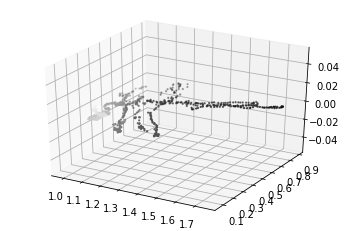

In [52]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(x,y,z, c=c)

plt.show()

In [130]:
x

array([  0.        , 200.        , 200.        , 202.70084425])

In [224]:
positions

[array([-3.34046343, -6.01443114,  0.01774478,  1.        ]),
 array([ -4.99176616, -13.31922525,   0.03120451,   1.        ]),
 array([ -5.51031814, -21.49190015,   0.0403146 ,   1.        ]),
 array([ -6.94563496, -28.42771744,   0.03729335,   1.        ]),
 array([-8.95788650e+00, -3.63107799e+01,  3.57078585e-02,  1.00000000e+00]),
 array([-1.27290775e+01, -3.88773091e+01,  2.97450367e-02,  1.00000000e+00]),
 array([-1.88860784e+01, -3.87361182e+01,  2.47458983e-02,  1.00000000e+00]),
 array([-2.45050827e+01, -3.82560980e+01,  2.38131571e-02,  1.00000000e+00]),
 array([-2.90887799e+01, -3.84207432e+01,  2.42577524e-02,  1.00000000e+00]),
 array([-3.23597754e+01, -3.87157506e+01,  2.10367916e-02,  1.00000000e+00]),
 array([-3.51292485e+01, -3.96466976e+01,  2.69915931e-02,  1.00000000e+00]),
 array([-3.61138530e+01, -4.04386840e+01,  1.98836026e-02,  1.00000000e+00]),
 array([-3.71084347e+01, -4.07223446e+01,  1.73717384e-02,  1.00000000e+00]),
 array([-3.74802139e+01, -4.11435685e+

In [16]:
import pandas as pd

In [63]:
df = pd.read_csv("./rgbd_dataset_freiburg1_floor/groundtruth.txt", header=None, delim_whitespace=True, comment='#')

In [64]:
df = df[[1,2,3]]

In [65]:
p = np.array(df)

In [66]:
x = p.T[0]
y = p.T[1]
z = p.T[2]
c = range(len(x))

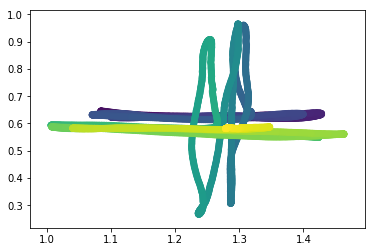

In [21]:

from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
plt.scatter(x,y,c=c)
plt.show()

x -0.7324 1.5688 y -1.2773 0.0289 z 0.5017 1.0765
x 0.2381467388899269 2.105912278569654 y -1.2632412932244177 0.972088163050999 z 0.5957948194730468 2.6158294213451336


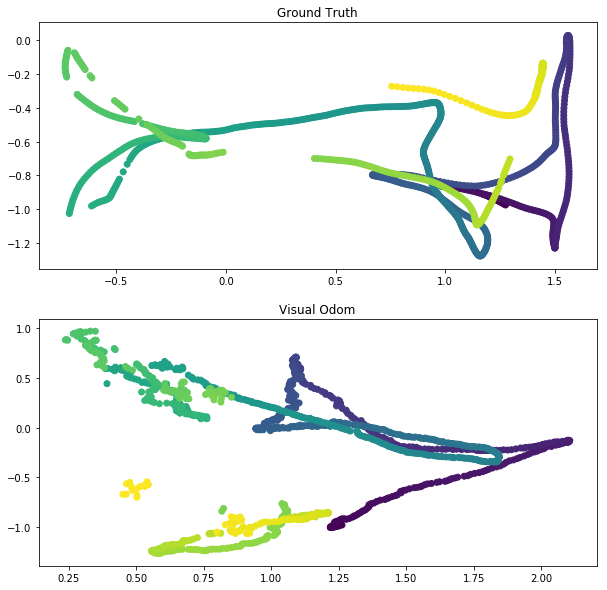

In [82]:
x = p.T[0][1::4]
y = p.T[1][1::4]
z = p.T[2][1::4]
print("x", min(x), max(x), "y", min(y), max(y), "z", min(z), max(z))
c = range(len(x))
f, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].scatter(x,y,c=c, cmap='viridis')
ax[0].set_title("Ground Truth")
x = np.array(pos_points).T[0]
y = np.array(pos_points).T[1]
z = np.array(pos_points).T[2]
print("x", min(x), max(x), "y", min(y), max(y), "z", min(z), max(z))
c = range(len(x))
ax[1].set_title("Visual Odom")
ax[1].scatter(x, y,c=c,cmap='viridis')
plt.savefig("Comparison.jpg")
plt.show()

In [70]:
depth = pd.read_csv("./rgbd_dataset_freiburg1_floor/depth.txt", header=None, delim_whitespace=True)
depth = depth[3:]
depth = depth[[0,1]]
depth.columns = ["timestamp", "depth_files"]
depth["timestamp"] = depth["timestamp"].astype(str)

In [71]:
rgb = pd.read_csv("./rgbd_dataset_freiburg1_floor/rgb.txt", header=None, delim_whitespace=True)
rgb = rgb[3:]
rgb = rgb[[0,1]]
rgb.columns = ["timestamp", "rgb_files"]
rgb["timestamp"] = rgb["timestamp"].astype(str)

In [4]:
s = 100
m = 100
test_img1 = np.zeros((700,700, 3), dtype=int)
test_img1[200:200+s, 300:300+s,:] = [125, 0, 100]
h1 = np.zeros((700,700), dtype=int)
h1[200:200+s+1, 300:300+s+1] = 5
test_img2 = np.zeros((700,700, 3), dtype=int)
test_img2[200+m:200+s+m, 300:300+s,:] = [125, 0, 100]
h2 = np.zeros((700,700), dtype=int)
h2[200+m:200+s+m+1, 300:300+s+1] = 5
test_img3 =  np.zeros((700,700, 3), dtype=int)
test_img3[200+m:200+s+m, 300+m:300+s+m,:] = [125, 0, 100]
h3 = np.zeros((700,700), dtype=int)
h3[200+m:200+s+m+1, 300+m:300+s+m+1] = 5
test_img4 =  np.zeros((700,700, 3), dtype=int)
test_img4[200+m + int(s/4):200+s+m- int(s/4), 300+m+ int(s/4):300+s+m- int(s/4),:] = [125, 0, 100]
h4 = np.zeros((700,700), dtype=int)
h4[200+m + int(s/4):200+s+m- int(s/4)+1, 300+m+ int(s/4):300+s+m- int(s/4)+1] = 10
test_img5 = np.zeros((700,700, 3), dtype=int)
test_img5[200-m:200+s-m, 300:300+s,:] = [125, 0, 100]
h5 = np.zeros((700,700), dtype=int)
h5[200-m:200+s-m+1, 300:300+s+1] = 5

img1_kp = [(200, 300), (200+s, 300), (200+s, 300+s), (200, 300+s), (200+int(s/2), 300), (200, 300+int(s/2)), (200+s, 300+int(s/2)), (200+int(s/2), 300+s)]
img2_kp = [(200+m, 300), (200+s+m, 300), (200+s+m, 300+s), (200+m, 300+s), (200+int(s/2)+m, 300), (200+m, 300+int(s/2)), (200+s+m, 300+int(s/2)), (200+int(s/2)+m, 300+s)]
img3_kp = [(200+m, 300+m), (200+s+m, 300+m), (200+s+m, 300+s+m), (200+m, 300+s+m), (200+int(s/2)+m, 300+m), (200+m, 300+int(s/2)+m), (200+s+m, 300+int(s/2)+m), (200+int(s/2)+m, 300+s+m)]
img4_kp = [(200+m + int(s/4), 300+m + int(s/4)), (200+s+m - int(s/4), 300+m + int(s/4)), (200+s+m- int(s/4), 300+s+m-int(s/4)), (200+m+int(s/4), 300+s+m-int(s/4)), (200+int(s/2)+m, 300+m+int(s/4)), (200+m+int(s/4), 300+int(s/2)+m), (200+s+m-int(s/4), 300+int(s/2)+m), (200+int(s/2)+m, 300+s+m-int(s/4))]
img5_kp = [(200-m, 300), (200+s-m, 300), (200+s-m, 300+s), (200-m, 300+s), (200+int(s/2)-m, 300), (200-m, 300+int(s/2)), (200+s-m, 300+int(s/2)), (200+int(s/2)-m, 300+s)]


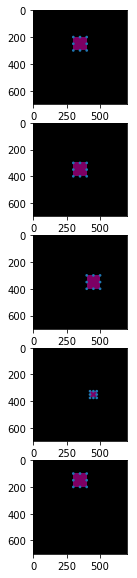

In [5]:

from matplotlib.patches import Circle
f, ax = plt.subplots(5,1, figsize=(10,10))
ax[0].imshow(test_img1)
for i in img1_kp:
    circ = Circle((i[1],i[0]),10)
    ax[0].add_patch(circ)
ax[1].imshow(test_img2)
for i in img2_kp:
    circ = Circle((i[1],i[0]),10)
    ax[1].add_patch(circ)
ax[2].imshow(test_img3)
for i in img3_kp:
    circ = Circle((i[1],i[0]),10)
    ax[2].add_patch(circ)
ax[3].imshow(test_img4)
for i in img4_kp:
    circ = Circle((i[1],i[0]),10)
    ax[3].add_patch(circ)
ax[4].imshow(test_img5)
for i in img5_kp:
    circ = Circle((i[1],i[0]),10)
    ax[4].add_patch(circ)

In [7]:
img1_points = []
img2_points = []
X_1 = np.array([0.0, 0.0, 0.0])
X_2 = np.array([0.0, 0.0, 0.0])
samples = 0
for i,(m,n) in enumerate(zip(img3_kp, img4_kp)):
    img1_points.append([m[0], m[1], h3[m[0],m[1]]])
    X_1 += img1_points[-1]
    img2_points.append([n[0], n[1], h4[n[0],n[1]]])
    X_2 += img2_points[-1]
    samples += 1
X_1 /= samples
X_2 /= samples
X1_points = np.array(img1_points)
X2_points = np.array(img2_points)
SVD_input = (X1_points-X_1).T @ (X2_points-X_2)
U,S,V = np.linalg.svd(SVD_input)
R = V.T @ U.T
t = X_2 - R @ X_1

In [6]:

K = np.array([[1/fx, 0, 0, cx], [0, 1/fy, 0, cy], [0, 0, 1, 0], [0, 0, 0, 1] ])
keypoints = [img1_kp, img2_kp, img3_kp, img4_kp, img5_kp, img1_kp]
depths = [h1, h2, h3, h4, h5, h1]
start = np.array([0,0,0,1])
translation = np.array([1.3563,  0.6305, 1.6380, 1])
rotation = Quaternion(0, 0, 0, 1)
position = np.zeros((4,4))
position[0:3,0:3] = rotation.rotation_matrix
position[:, 3] = translation
positions = []
for j in range(1, len(keypoints)):
    img1_points = []
    img2_points = []
    X_1 = np.array([0.0, 0.0, 0.0])
    X_2 = np.array([0.0, 0.0, 0.0])
    samples = 0
    for i,(m,n) in enumerate(zip(keypoints[j-1], keypoints[j])):
        img1_points.append([(m[0] - cx) * depths[j-1][m[0],m[1]]/ fx, (m[1] - cy) * depths[j-1][m[0],m[1]]/ fy, depths[j-1][m[0],m[1]]])
        X_1 += img1_points[-1]
        img2_points.append([(n[0] - cx) * depths[j][n[0],n[1]]/ fx, (n[1] - cy) * depths[j][n[0],n[1]]/ fy, depths[j][n[0],n[1]]])
        X_2 += img2_points[-1]
        samples += 1
    X_1 /= samples
    X_2 /= samples
    print(X_1)
    print(X_2)
    X1_points = np.array(img1_points)
    X2_points = np.array(img2_points)
    SVD_input = (X1_points-X_1).T @ (X2_points-X_2)
    U,S,V = np.linalg.svd(SVD_input)
    R = V.T @ U.T
    t = X_2 - R @ X_1
    print(t)
    transformation = np.zeros((4,4))
    transformation[0:3,0:3] = R
    transformation[0:3,3] = t
    transformation[3,3] = 1
    positions.append(position[0:3, 3])
    position = position @ transformation
    start = position.copy()

positions.append(position[0:3, 3])
    

[-0.66305819  0.91674734  5.        ]
[0.30349894 0.91674734 5.        ]
[0.96655712 0.         0.        ]
[0.30349894 0.91674734 5.        ]
[0.30349894 1.88480155 5.        ]
[0.         0.96805421 0.        ]
[0.30349894 1.88480155 5.        ]
[ 0.60699787  3.7696031  10.        ]
[0.30349894 1.88480155 5.        ]
[ 0.60699787  3.7696031  10.        ]
[-1.62961531  0.91674734  5.        ]
[-2.23661318 -2.85285576 -5.        ]
[-1.62961531  0.91674734  5.        ]
[-0.66305819  0.91674734  5.        ]
[0.96655712 0.         0.        ]


In [7]:
positions

[array([1.3563, 0.6305, 1.638 ]),
 array([0.38974288, 0.6305    , 1.638     ]),
 array([ 0.38974288, -0.33755421,  1.638     ]),
 array([ 0.08624394, -2.22235576,  6.638     ]),
 array([2.32285712, 0.6305    , 1.638     ]),
 array([1.3563, 0.6305, 1.638 ])]

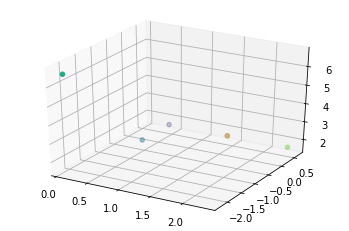

In [8]:
x = np.array(positions).T[0]
y = np.array(positions).T[1]
z = np.array(positions).T[2]
c = range(len(x))
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,c=c, cmap='viridis')
plt.show()